Make synthetic worm datasets containing sinusoidal signals and visualize them.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import random


def create_synthetic_data(
    seq_len,
    num_signal,
    num_worms,
    if_noise=False,
    sum_frequencies=0,
    if_sequence=False,
    noise_sd=0.02,
):
    datasets = []

    for worm_idx in range(num_worms):
        calcium_data = np.zeros((seq_len, num_signal))
        residual_calcium = np.zeros((seq_len, num_signal))
        time_points = np.arange(seq_len)

        for i in range(num_signal):
            frequencies = [
                np.random.uniform(1.0 / seq_len, 5 * 1.0 / seq_len)
                for _ in range(sum_frequencies + 1)
            ]
            phases = [
                np.random.random() * 2 * np.pi for _ in range(sum_frequencies + 1)
            ]

            if if_sequence:
                frequencies[0] = 1.0 / seq_len * (i + 1)

            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, seq_len)

        residual_calcium[1:] = calcium_data[1:] - calcium_data[:-1]

        # Creating masks and indices for known and unknown neurons
        num_unnamed_neurons = 100
        unknown_neurons_indices = random.sample(range(num_signal), num_unnamed_neurons)
        named_neurons_indices = list(
            set(range(num_signal)) - set(unknown_neurons_indices)
        )
        named_neurons_mask = np.full((num_signal,), True)
        named_neurons_mask[unknown_neurons_indices] = False

        worm_data = {
            "calcium_data": torch.tensor(calcium_data, dtype=torch.float32),
            "residual_calcium": torch.tensor(residual_calcium, dtype=torch.float32),
            "named_neurons_mask": torch.tensor(named_neurons_mask),
            "named_neuron_to_idx": named_neurons_indices,
            "idx_to_named_neuron": named_neurons_indices,
            "num_neurons": num_signal,
            "num_named_neurons": num_signal - num_unnamed_neurons,
            "num_unknown_neurons": num_unnamed_neurons,
        }

        datasets.append(worm_data)

    return datasets


def save_datasets(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


seq_len = 3312
num_signal = 302
num_worms = 6

# Creating and saving datasets
datasets = create_synthetic_data(
    seq_len,
    num_signal,
    num_worms,
    if_noise=True,
    sum_frequencies=8,
    if_sequence=False,
    noise_sd=0.1,
)
save_datasets("../data/processed/neural/sine_noise.pickle", datasets)

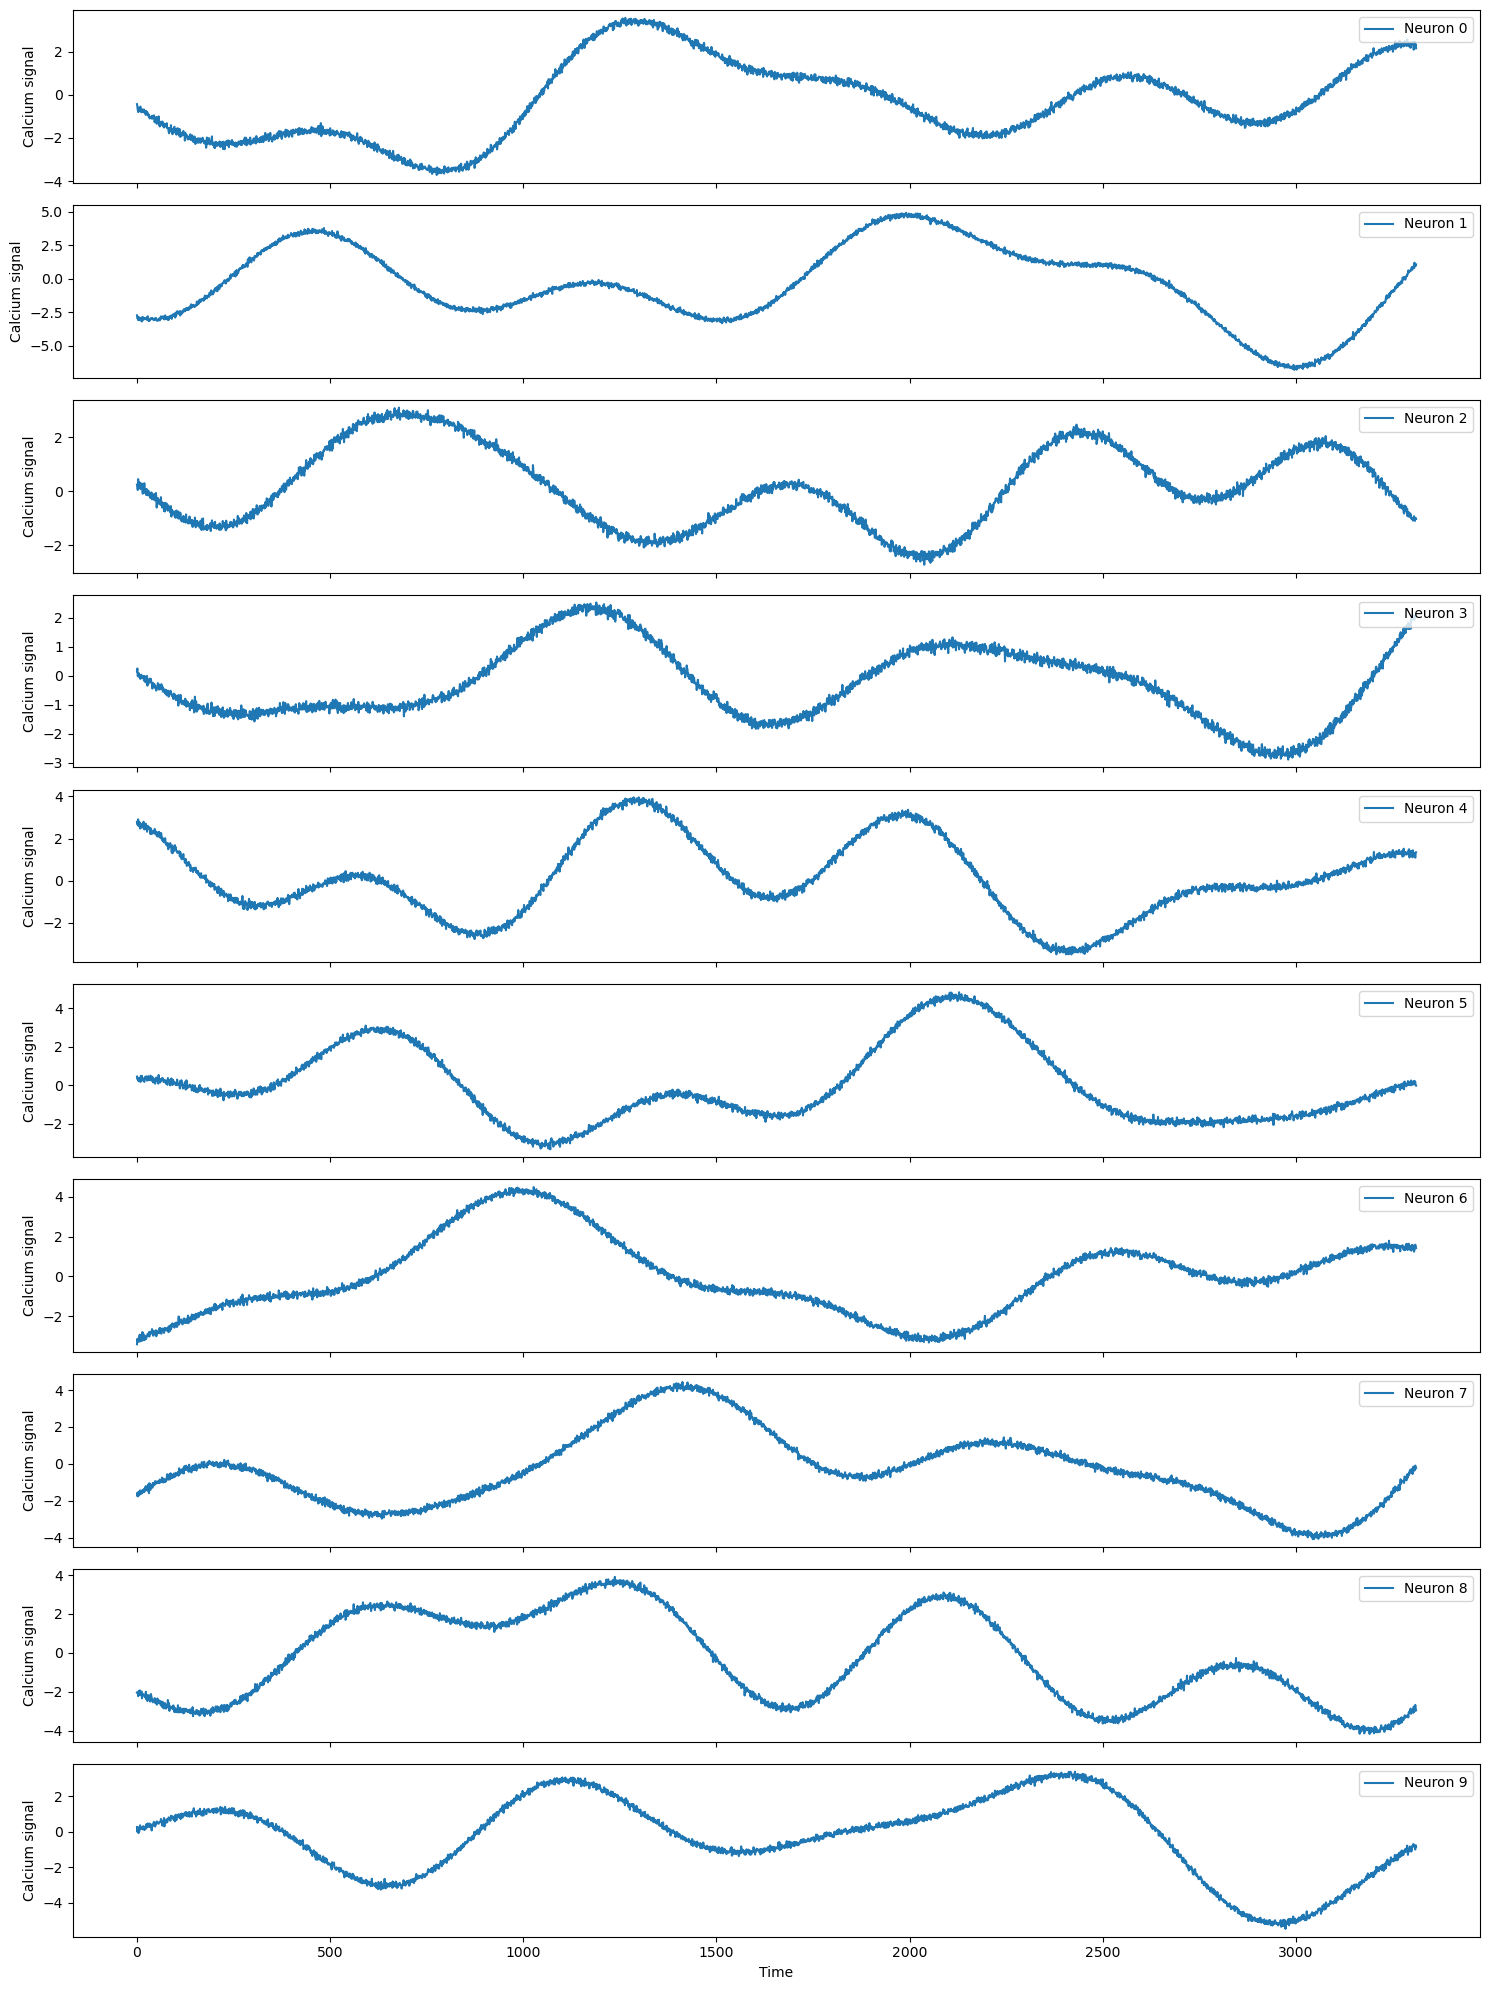

In [15]:
def plot_calcium_signals(dataset, num_neurons_to_plot=None):
    calcium_data = dataset["calcium_data"].numpy()
    num_neurons = calcium_data.shape[1]
    time_points = np.arange(calcium_data.shape[0])

    if num_neurons_to_plot is None:
        num_neurons_to_plot = num_neurons

    fig, axes = plt.subplots(
        num_neurons_to_plot, 1, figsize=(15, 2 * num_neurons_to_plot), sharex=True
    )

    for idx, ax in enumerate(axes):
        ax.plot(time_points, calcium_data[:, idx], label=f"Neuron {idx}")
        ax.set_ylabel("Calcium signal")
        ax.legend(loc="upper right")

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()


# Load a dataset from the file
with open("../data/processed/neural/sine_noise.pickle", "rb") as f:
    datasets = pickle.load(f)

# Plot calcium signals for the first worm in the dataset
plot_calcium_signals(datasets[0], num_neurons_to_plot=10)
